# Deep Learning on Differential Equations: a Case Study with NODEs and the Double Pendulum
Eli Child, Ian Goodwin, DT Litster, Jared Smith

December 17, 2024

## Abstract

Double pendulums are known for their chaotic nature and provide highly nonlinear partial differential equations. This study aims to learn the performance of physics-informed deep neural networks on physics-related problems. We compare a basic NODE architecture to a hybrid PINN architecture. Using an ablation study, we examined the performance of NODEs across different model sizes, varying amounts of noise, number of training samples, and varying lengths of each trajectory. Our study shows that increased noise significantly reduced the time to divergence and increased global error, more training samples modestly improves performance, and larger models decreased the time to divergence with limited improvement to global error. We also find that even with noise, NODEs are typically a better model of long-term dynamics than basic PINNs.

## Introduction

In this project, our goal was to learn how deep neural networks perform on physics-related problems when the neural network itself has physics-related concepts built into its architecture. The particular problem we used to investigate this question was prediction of the future state of a double pendulum system, as the system is governed by relatively simple ordinary differential equations (ODEs) but exhibits chaotic behavior, making the learning task nontrivial. Using a deterministic (if chaotic) system allowed us to generate effectively infinite data as we needed it; when data was required for training or validation, we simply generated random starting points and used the differential equations to generate time series beginning with those points.

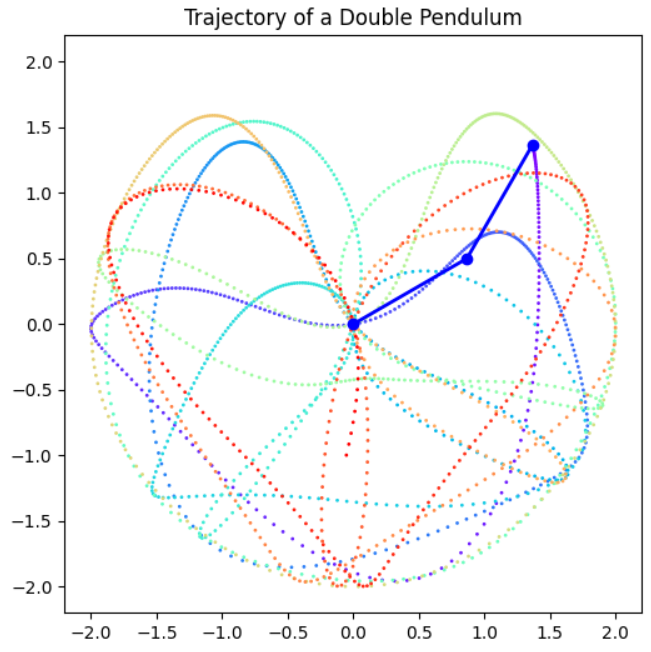

In [1]:
from IPython.display import Image
Image(filename='dp_trajectory.png')

Figure 1. As shown by the trajectory above, double pendulums are extremely chaotic and are highly sensitive to initial conditions.

In [ ]:
from matplotlib import animation
import numpy as np

from animation_generation import generate_animation_three_double_pendulum_systems

animation.writer = animation.writers['ffmpeg']

# This takes ~35 seconds to run on one of the author's machines
generate_animation_three_double_pendulum_systems(l1=1.0, l2=1.0, m1=1.0, m2=1.0, t_final=20.0,
                        animation_name='chaos_demonstration', initial_offset=1e-6, num_tsteps=2000,
                        theta1_init=np.pi - 1e-1, theta2_init=np.pi + 1e-1, z1_init=0.0, z2_init=0.0)

<video src='chaos_demonstration.mp4' controls>

Figure 2. Animation of double pendulum simulated using SciPy.integrate's solve_ivp. Figure can be re-generated with different parameters if desired.

### NODE Literature Review

We focused primarily on neural ODEs (NODEs) in our experiments. NODEs are a conceptual extension of residual networks (ResNets) or recurrent neural networks (RNNs) in the sense that they represent relevant information about a time series through the use of a hidden state which is updated as time moves forward (Chen, Rubanova, Bettencourt \& Duvenaud). However, while ResNets and RNNs perform updates in discrete time, NODEs operate in continuous time. Effectively, an RNN or similar model is trained to approximate the function that maps from the value of the hidden state at time index $t$ to the value of the hidden state at time $t+1$. A NODE instead approximates a continuous derivative of the hidden state at any time. This allows the trained neural network to be used as the derivative function in a black-box numerical ODE solver, the result of which can be decoded into a prediction at an arbitrary future time with constant computational cost. Put another way, NODEs mimic the limit of applying RNNs to a problem as the size of the discrete timestep used by the RNNs goes to 0.

NODEs can be applied to problems in physics quite naturally. Many physical problems involve differential equations, and any such problem could benefit from using a NODE. Using a NODE when a differential equation is involved is a good inductive hypothesis, as we demonstrate in the rest of this paper; however, it is worth noting that in the presence of noise, NODEs may benefit from additional structures that help mitigate the effect of noise. Researchers have found NODEs to have certain limitations such as a lack of adaptation to new data, an inability to capture underlying dynamics (Norcliffe, Bodnar, Day, Moss, \& Lio), and a need to use hundreds of layers in order to train on large datasets (Finlay, Jacobsen, Nurbekyan, \& Oberman). In their research, Finlay et al. introduce a "combination of both optimal transport and stability regularizations which encourage neural ODEs to prefer simpler dynamics out of all the dynamics that solve a problem well" so as to overcome the difficulty of NODEs during training. Additionally, Norcliffe et al. introduces Neural ODE Processes that capture the underlying dynamics of low-dimensional systems along with being able to scale well for high-dimensional systems. Rather than risk obfuscating the performance or lack thereof, we chose to implement the original NODE architecture as described by Chen et al.

### PINN Literature Review

We also considered applying Physics-Informed Neural Networks (PINNs) to the task of predicting future states of a double pendulum system. PINNs are deep neural networks whose objective function contains a term penalizing divergence from observed training data as well as a term penalizing divergence from some amount of preexisting knowledge about the physics of the system.

A wide variety of architectures and approaches fall under this umbrella. The authors who introduced the term (Raissi, Perdikaris, \& Karniadakis) first described a method with high physics knowledge that was effectively a neural network used to solve a particular initial value problem. Other researchers applied this general method to the double pendulum problem and found that PINNs can fail to capture chaotic dynamics because they deviate slightly from given initial conditions in order to match training trajectories (Steger, Rohrhofer, \& Geiger). On the other hand, later works took the opposite approach and set out to derive the governing equations of motion from data, such as Dufera, T. T. We were most interested in a hybrid approach such as that described by Karniadakis et al, in which models learn from both data and some pre-knowledge about system physics.

The most obvious initial investigation to us was the application of a straightforward multilayer perceptron (MLP) model with a PINN loss to map between discrete time points in the state of the system. In other words, we would train a neural network to take in the positions and velocities of both pendulums and output a prediction for those values a small, constant time interval later. However, upon further reflection, we realized that in the case that training data are generated without noise, the data perfectly follow the physics, and the data loss and the physics loss are equivalent. As a result, the network would not truly be a PINN. We thus chose to focus mostly on NODEs, and use "PINNs" (which here are equivalent to a MLP with a data-only loss) as a control for comparison purposes. As a result, throughout our work, we refer interchangeably to these experiments as PINN experiments and as control experiments.

## Methods

We forewent a traditional dataset in favor of online data generation to ease comparison across various tasks. We generated data using scipy's `solve_ivp` with $\Delta t = 0.005\mathrm{s}$ on the true derivative of the double pendulum system to create a ground-truth trajectory. When generating noisy data, we then injected noise by adding $\boldsymbol{\varepsilon} \sim \mathcal{N}(\textbf{0}, \sigma^2 I)$ to the trajectory.

The control model was a feedforward multilayer perceptron with 3 hidden layers of dimension 30. Its training data were noiseless and all used pendula with equal masses (1kg) and equal lengths (1m); they consisted of input-output pairs of four variables each, with the angles and angular velocities of each pendulum at one point in time as input and the output being those same four variables .005s later. Angles were generated uniformly between $-\pi$ and $\pi$ radians, and velocities were chosen from a normal distribution centered at 0. The training was done over 450,000 epochs, each of which consisted of $2^{15}$ training pairs. The loss was simple mean squared error (MSE) on vectors in $\mathbb{R}^4$.

Our NODEs were MLPs with tanh nonlinearities. The model was then run through the `odeint` function of the `torchdiffeq` package developed by the original authors of the NODE paper (Chen, Rubanova, Bettencourt \& Duvenaud) to produce the new sequence of timesteps. Again, loss was MSE on the resulting vectors. The specifics of model size, amount of noise, trajectory length and number of training samples were varied during our ablation study, as summarized below.



*   For model size, we had 3 models with 1, 2 and 3 hidden layers. The size of the hidden layers were [32], [64, 64], and [64, 128, 64], respectively.
*   We then assigned maximum and minimum trajectory lengths and had the dataset generate trajectories of lengths uniformly sampled between them. Our trajectory lengths were then chosen to be in one of the following bins: [3, 8], [10, 15], [18, 23].
*   We added noise by adding $\boldsymbol{\varepsilon} \sim \mathcal{N}(\textbf{0}, \sigma^2 I)$ for $\sigma^2\in \{0.05, 0.5\}$. We also trained with no noise (denoted $\sigma^2 = 0$ in this notebook).
*   We tried training for a total of $|X| \in \{200, 500, 1000\}$ trajectories.

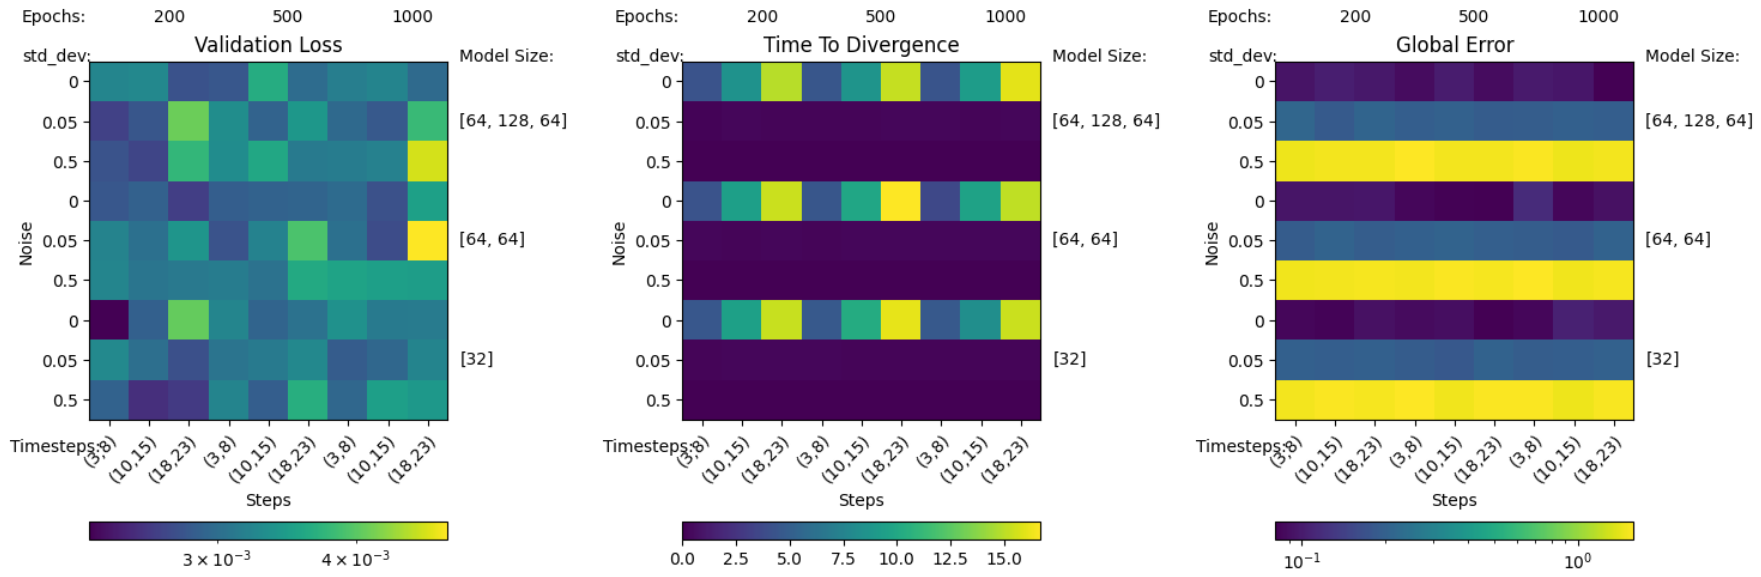

In [2]:
Image(filename='heatmap_metrics2.png')

Figure 3. Heatmaps of three metrics where each square represents a different model composed of unique variables. Each set of three rows represents the size of the model and is further subdivided by the variations of added noise. Each set of three columns represents the number of training trajectories. The columns are further divided into trajectory lengths. Validation is averaged over the entire training sequence, and TTD and GE are averaged over 200 epochs.

Our NODE used tanh for its nonlinearities, and layers in the middle were twice as large as layers near the edge, i.e. a layer of 64, 128, then 64 again. Our PINNs and vanilla MLPs were similar, but used ReLU for the nonlinearities. See Figure 4 below for a sample training trajectory.

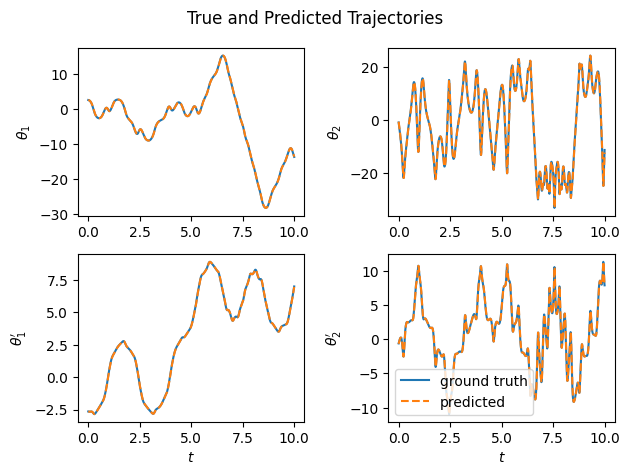

In [3]:
Image(filename='trajs.png')

Figure 4. A NODE's predicted trajectory (dotted orange line) compared to the true trajectory (blue line).

## Results

### NODE Ablation Study

As you can see in Figure 3 above, the biggest factor in NODE performance was the added noise. Introducing more noise quickly reduced the time until divergence to near zero and significantly increased global error. Longer training sequences had a modest positive effect on global error and time to divergence. The number of training trajectories (epochs) was more nuanced; we see that 200 trajectories performed a little worse on both metrics, but 500 and 1000 trajectories have similar performance. Larger models see only modest gains in global error but are able to achieve a better time to divergence in the absence of noise. However, smaller models are surprisingly effective in the absence of noise.

While the time to divergence and global error have clear trends, validation loss does not. The heat map of validation loss essentially looks like random noise. The large model with noise $\sigma^2 = 0.05$ trained for 1000 epochs with training sequences between 18 and 25 timesteps had an unusually large loss value, but this is probably a fluke. All other models had very small loss, indicating good generalization error on average.

### PINNs/Control

PINNs performed notably worse than NODEs at the task of predicting the future state of a double pendulum. Across 1000 ten-second simulations of double pendulum behavior generated by iterating the next-step predictions of a PINN, the average global error was 2.49 (rounded to the nearest hundredth), compared to the maximum average error for NODEs of less than $10^{0.1}\approx1.26$. Interestingly, the average time to divergence for PINNs was about 25.6, which again exceeds the maximum found in the ablation study, meaning that PINNs took longer to deviate by more than 0.1 from the true solution as measured by the vector norm. However, visual inspection of example plots such as the one found in Figure (currently 4 but confirm before turning in), in comparison to similar plots for NODEs, reveals that while our PINNs may take longer to diverge, they usually become totally decoupled from the true dynamics of the pendulum, where NODEs do not, for an overall worse predictor of long-term dynamics.

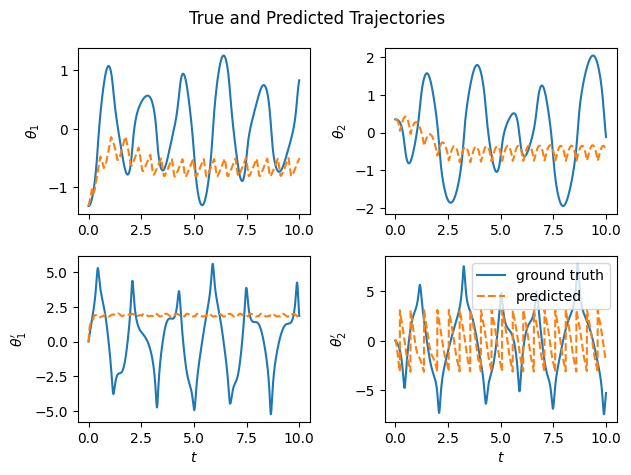

In [4]:
Image(filename='PINN_traj.png')

Figure 5. A PINN's predicted trajectory (orange) compared to the true trajectory (blue). Despite diverging at similar times to NODEs, PINNs deviate significantly more from the actual path of the double pendulum and don't result in very chaotic dynamics.

## Analysis

Our results indicate mainly what one should expect; larger models and more data are a little better, while noisier data is a lot worse for the training process of NODEs. This suggests that care should be taken when working with noisy datasets, and where appropriate, noise reduction techniques might improve model performance more than access to more data or training larger models.

One possible reason for the apparent noisiness of the validation loss is that the loss averages MSE across the entire validation sequence. If most errors are small, this significantly decreases the average error. In contrast, the global error looks at the largest MSE across the sequence. Thus, while our models have some clear patterns when it comes to worst-case performance along a given trajectory, when it comes to average performance, they are very similar. This suggests that when training a NODE, you might be able to get better performance if you train against a worst-case metric like global error rather than an average-case metric like MSE.

When noise is small, however, NODEs demonstrate a clear advantage in physics-related systems over straightforward feedforward networks that aren't built to work with ODEs. Where the control model quickly became totally decoupled from the true system dynamics, NODEs were often near-perfect models. Furthermore, while NODEs achieved the reported results in the space of at most 1000 epochs of one sequence each, for a total of at most 22,000 input-output pairs, PINNs were trained for hundreds of times more epochs with tens of thousands of such pairs, meaning that NODEs perform better with orders of magnitude less training.

The performance of NODEs relative to a control of similar size suggests that in the absence of noise, a model built to approximate a differential equation will unsurprisingly learn to capture the dynamics of a real ODE much more effectively than will a model that doesn't structure itself with ODEs in mind. We tentatively attribute this difference to two factors. First and foremost, training the network to approximate an instantaneous derivative allows the model to use numerical methods with time steps much smaller than those it was trained on. This allows it to generate solutions using more accurate and stable methods, such as `solve_ivp`, where the MLP used the less powerful forward Euler method by necessity. In addition, slicing time in finer increments prevents errors from one step to the next from propagating quite as wildly, slowing the rate of divergence from the true solution in the chaotic system.

Secondly, NODEs were trained using sequences of observations in a system rather than a single input-output pair. We believe this may have helped NODEs to develop a better internal representation of subtleties in the dynamics of the pendulum; in particular, details that don't make a substantial difference in state across one timestep, but that result in large long-term differences, as is characteristic of chaotic systems.

## Conclusions

This study demonstrates the effectiveness of NODEs regardless of the model size or the number of training samples used. Additionally, we see an improved performance when given a longer length of each training sample trajectory; however, our study also shows the NODEs' sensitivity to noise.

Our work also examines the advantages of using physics-aware models on physical systems via a comparison to a vanilla MLP. While such vanilla models may take longer to diverge by a given amount from a true trajectory, they typically decouple entirely from it, whereas physics-aware models have a significantly better overall error. By the same token, this study also demonstrates the relative weakness of PINNs when trained on data that perfectly adheres to a given physics system. The major lessons we learned in this project are that architecture-level awareness of the ODE-based nature of the problem significantly improves model performance, and that noise significantly impacts the training capabilities of models that have no prior on the nature of the system physics.

Future studies could include examining the effects of various noise-reduction techniques in NODE performance, although care must always be taken to ensure the noise reduction is appropriate. While data derived from a physical process might be expected to follow a smooth trajectory, other applications such as economic data might not be reasonably smoothed.

Another possible line of research would examine the effects of training with a metric that attempts to assess the worst-case scenario along a given trajectory rather than the average-case scenario. It's possible that pretraining with average-case and then fine-tuning with worst-case would also work. However, one struggle is that worst-case metrics may be less differentiable or reduce the amount of information that flows from a data sample back into the network; it could be worth averaging the performance on the $k$ worst points in a trajectory for some small $k$.

## Hours Log

A log of hours spent by each member of the team can be found at

https://docs.google.com/spreadsheets/d/1Yal1bySpmQq\_eftm39ZrnhVWGzIxTo-1cvC65B2gCgI/edit?usp=sharing.

Note that each member has a separate tab in the sheet, found at the bottom of the page.

## References

Chen, R., Rubanova, Y., Bettencourt, J., Duvenaud D. (2019). Neural Ordinary Differential Equations. arxiv.org/pdf/1806.07366

Dufera, T. T. (2021). Deep neural network for system of ordinary differential equations: Vectorized algorithm and simulation. Machine Learning with Applications, 5, 100058.

Finlay, C., Jacobsen, J., Nurbekyan, L., Oberman, A. (2020). How To Train Your Neural ODE. ResearchGate.net

Karniadakis, G. E., Kevrekidis, I. G., Lu, L., Perdikaris, P., Wang, S., \& Yang, L. (2021). Physics-informed machine learning. Nature Reviews Physics, 3(6), 422-440.

Norcliffe, A., Bodnar, C., Day, B., Moss, J., \& Lio, P. (2021). Neural ODE Processes. doi.org/10.48550/arXiv.2103.12413

Raissi, M., Perdikaris, P., \& Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561.

Steger, S., Rohrhofer, F. M., \& Geiger, B. C. (2022). How PINNs cheat: Predicting chaotic motion of a double pendulum. In The Symbiosis of Deep Learning and Differential Equations II.

## NODE Experiments

In [ ]:
import matplotlib.pyplot as plt
import torch
!pip install torchdiffeq
from torchdiffeq import odeint
from torch.utils.data.dataloader import DataLoader
from metrics import one_step_error, time_to_divergence, global_error
from train import train_model, plot_results
from neural_ode import Pendulum_Data


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
num_epochs = 1000
dims = [64,128,64]
std_dev = 0.05
min_steps = 18

model, train_losses, val_losses = train_model(num_epochs, dims, std_dev, min_steps)
test_dataset = Pendulum_Data(min_steps, min_steps+5, G=9.81, delta_t=.005, size=1)
test_dloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 1000/1000 [00:13<00:00, 72.22it/s]


Time to Divergence: 0
Global Error 0.5031047 



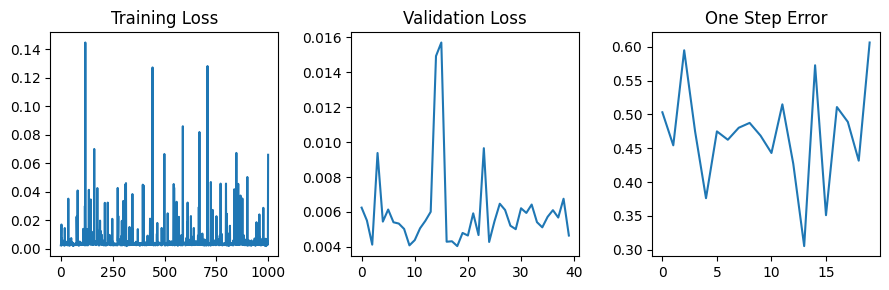

In [ ]:
for X_batch, y_batch in test_dloader:
    X_batch += np.random.normal(0, std_dev, X_batch.shape)
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
    y_pred = odeint(model, X_batch[:, :, 4:], 0.005 * torch.arange(len(X_batch)+1))[1:]
    y_batch = y_batch[:, :, 4:]

time_to_dvgence = time_to_divergence(y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1)
global_err = global_error(len(X_batch)+1, y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1)
onestep_err = one_step_error(y_pred.squeeze().detach().numpy(), y_batch.squeeze().detach().numpy(), 1)

print("Time to Divergence:", time_to_dvgence)
print("Global Error", global_err, "\n")

plot_results(train_losses, val_losses, onestep_err)